In [2]:
import os
import sys
import time
import pickle

import numpy as np
#import xlsxwriter
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import data_loader

from utils import *
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, BatchNormalization, ReLU, Conv2D, Reshape
from tensorflow.keras import Model , regularizers

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras
tfkd= tf.keras.datasets
tf.keras.backend.set_floatx('float32')
os.makedirs('./ring_samples_sigmoid/gan', exist_ok=True)

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[3],'GPU')

# tf.keras.utils.set_random_seed(100)
# tf.config.experimental.enable_op_determinism()


2024-04-10 03:23:00.395527: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 03:23:00.438634: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 03:23:00.438674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 03:23:00.438708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-10 03:23:00.447732: I tensorflow/core/platform/cpu_feature_g

In [3]:
num_classes = 32
temp_val = np.linspace(0.05,2.05,num_classes)

In [4]:
num_classes = 32
temp_val = np.linspace(0.05,2.05,num_classes)

xy_data = np.float32(data_loader.load_data_mh_generated('./data/8x8_gibbslattices.pkl'))/(2*np.pi)

trainset  = []
testset   = []
   
for i in range(num_classes):
    trainset.append(xy_data[10000*i+2000:10000*i+7120])
    testset.append(xy_data[10000*i+7952:10000*(i+1)])

trainset = np.reshape(np.array(trainset),(-1,8,8,1))
testset  = np.reshape(np.array(testset),(-1,8,8,1))

train_temp = np.repeat(temp_val,5120)
test_temp  = np.repeat(temp_val,2048)

batch_size = 512

train_T    = tf.cast(np.repeat(train_temp,8*8).reshape(-1,8,8,1),dtype = tf.float32)
test_T     = tf.cast(np.repeat(test_temp,8*8).reshape(-1,8,8,1),dtype = tf.float32)
train_temp = tf.cast(train_temp.reshape(-1,),dtype=tf.float32)



training_dataset = tf.data.Dataset.from_tensor_slices((trainset,train_T,train_temp))
training_dataset = training_dataset.shuffle(buffer_size = 1024).batch(batch_size)
    
test_dataset = tf.data.Dataset.from_tensor_slices((testset,test_T))
test_dataset = test_dataset.batch(batch_size)
    

2024-04-10 03:23:04.068184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8244 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:3f:00.0, compute capability: 8.6


In [5]:
def checkerboard(height, width, reverse=False, dtype=tf.float32):
    checkerboard = [[((i % 2) + j) % 2 for j in range(width)] for i in range(height)] 
    checkerboard = tf.convert_to_tensor(checkerboard, dtype = dtype)
    if reverse:
        checkerboard = 1 - checkerboard
    
    checkerboard = tf.reshape(checkerboard, (1,height,width,1))
        
    return tf.cast(checkerboard, dtype=dtype)


In [6]:
filters = 64

def Coupling(input_shape):
    input1 = keras.layers.Input(shape=input_shape)
    input2 = keras.layers.Input(shape=input_shape)
    input  = tf.concat([input1,input2],axis=-1)
    
    layer1 = keras.layers.Conv2D(filters,3, activation="relu",padding = 'valid',name = 'layer1')(periodic_padding(input,1))
    layer2 = keras.layers.Conv2D(filters,3, activation="relu",padding = 'valid',name = 'layer2')(periodic_padding(layer1,1))
    t_layer= keras.layers.Conv2D(1,3,padding = 'valid',name = 't_layer')(periodic_padding(layer2))
    s_layer= keras.layers.Conv2D(1,3,activation = 'tanh',padding = 'valid', name = 's_layer')(periodic_padding(layer2))

    return keras.Model(inputs=[input1,input2], outputs=[s_layer, t_layer])

In [7]:
class SimpleNormal:
    def __init__(self, loc, var):
        self.dist = tfd.Normal(tf.reshape(loc,(-1,)), tf.reshape(var,(-1,)))
        self.shape = loc.shape
    def log_prob(self, x):
        logp = self.dist.log_prob(tf.reshape(x,(x.shape[0], -1)))
        return tf.reduce_sum(logp, axis=1)
    def sample_n(self, batch_size , seed = None):
        x = self.dist.sample((batch_size,),seed = seed)
        return tf.reshape(x,(batch_size, *self.shape))

In [8]:
def xy_action(lattice):
    xp = tf.roll(lattice,shift=1, axis=2)
    xn = tf.roll(lattice,shift=-1, axis=2)
    yp = tf.roll(lattice,shift=[0,1,0], axis=[0,1,2])
    yn = tf.roll(lattice,shift=[0,-1,0], axis=[0,1,2])
    H_matrix = -1*(tf.math.cos(2*np.pi*(xp-lattice)) + tf.math.cos(2*np.pi*(xn-lattice))+ tf.math.cos(2*np.pi*(yp-lattice)) + tf.math.cos(2*np.pi*(yn-lattice)))
    energy  = tf.reduce_sum((H_matrix),axis =[1,2])/2
    return energy

In [9]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers,input_shape , data_constraint):
        super().__init__()

        self.num_coupling_layers = num_coupling_layers
        self.distribution = SimpleNormal(tf.zeros((8,8)), tf.ones((8,8)))
        self.masks = [checkerboard(input_shape[0],input_shape[1], reverse=False),checkerboard(input_shape[0],input_shape[1], reverse=True)]*(num_coupling_layers // 2)
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(input_shape) for i in range(num_coupling_layers)]
        self.data_constraint = data_constraint



    def call(self, x, forward=True):
        if forward:
            (x1,x2) = x 
            alpha = tf.constant(self.data_constraint)
            logq = self.distribution.log_prob(tf.reshape(x1,(-1,8,8)))
            x,ldj1 = self.forward(x)
            (x1,x2)= x
            ldj2 = tf.math.softplus(x1) + tf.math.softplus(-x1) + tf.math.log(tf.constant(1.-2*self.data_constraint)) 
            ldj2 = tf.reduce_sum(ldj2,[1,2,3])
            logq = logq - ldj1 + ldj2
            x1   = (tf.math.sigmoid(x1) - alpha)/(1-2*alpha)
            x = (x1,x2)
            return x, logq
        else:
            (x1,x2) = x
            x1 = self.data_constraint + (1-2*self.data_constraint)*x1
            x1 = tf.math.log(x1/(1.-x1)) 
            # Save log-determinant of Jacobian of initial transform
            ldj1 = tf.math.softplus(x1) + tf.math.softplus(-x1) + tf.math.log(tf.constant(1.-2*self.data_constraint))
            ldj1 = tf.reduce_sum(ldj1,[1,2,3])
            x = (x1,x2)
            x,ldj2 = self.reverse(x)
            (x1,x2) = x
            logq = self.distribution.log_prob(tf.reshape(x1,(-1,8,8)))
            logq = logq + ldj2 + ldj1
            return x , logq   
            
    


    def forward(self, x):
        ldj = 0
        for i in range(self.num_coupling_layers):
            (x1,x2) = x
            
            x_frozen = x1 * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            x_active = x1 * reversed_mask
            s, t = self.layers_list[i]([x_frozen,x2])
            s *= reversed_mask
            t *= reversed_mask
            
            fx1 = t + x_active *tf.exp(s) + x_frozen
            fx2 = x2
            ldj += tf.reduce_sum(s, [1,2,3])
            x = (fx1,fx2)
        return x, ldj
              
    def reverse(self, fx):
        ldj = 0
        for i in reversed(range(self.num_coupling_layers)):
            (fx1,fx2)= fx
            fx_frozen = fx1*self.masks[i]
            reversed_mask = 1 - self.masks[i]
            fx_active = fx1*reversed_mask
            s, t = self.layers_list[i]([fx_frozen,fx2])
            s *= reversed_mask
            t *= reversed_mask
            
            x1 = (fx_active - t) *tf.exp(-s) + fx_frozen
            x2 = fx2
            ldj -= tf.reduce_sum(s, [1,2,3])
            fx = (x1,x2)
        return fx,ldj
        
     
    
   

In [10]:
def discriminator_model():
    input1 = tfk.Input(shape = (8,8,1))
    input2 = tfk.Input(shape = (8,8,1))
    
    inputs = tfk.layers.concatenate([input1,input2],axis=3)
    layer1 = tfk.layers.Conv2D(64 ,(3,3),strides=1,padding='valid',activation='tanh',name='layer1')(periodic_padding(inputs,1))
    layer2 = tfk.layers.Conv2D(64 ,(3,3),strides=1,padding='valid',activation='tanh',name='layer2')(periodic_padding(layer1,1))
    layer3 = tfk.layers.MaxPooling2D(pool_size=(2,2),padding='valid',name='layer3')(layer2)
    layer4 = tfk.layers.Conv2D(64 ,(3,3),strides=1,padding='valid',activation='tanh',name='layer4')(layer3)
    layer5 = tfk.layers.Reshape((2*2*64,))(layer4)
    layer6 = tfk.layers.Dense(64,activation='tanh',name='layer6')(layer5)
    layer7 = tfk.layers.Dense(16,activation='tanh',name='layer7')(layer6)
    output = tfk.layers.Dense(1,name='output')(layer7)
    model = tfk.Model(inputs = (input1,input2),outputs= output,name='Discriminator_Model')
    
    model.summary()
    return model
   

In [11]:
generator = RealNVP(24,(8,8,1),1.e-4)
discriminator = discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)


Model: "Discriminator_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_49 (InputLayer)       [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 input_50 (InputLayer)       [(None, 8, 8, 1)]            0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 8, 8, 2)              0         ['input_49[0][0]',            
                                                                     'input_50[0][0]']            
                                                                                                  
 tf.__operators__.getitem_7  (None, 1, 1, 2)              0         ['concatenat

In [12]:
boundaries = [1250*1, 1250*2, 1250*3, 1250*4, 1250*5, 1250*6, 1250*7, 1250*8, 1250*9, 1250*10]
 
gen_lr = 1.e-5
dis_lr = 5.e-5
decay  = 0.95
      
values_gen = [gen_lr, gen_lr*decay, gen_lr*(decay)**2, gen_lr*(decay)**3, gen_lr*(decay)**4,
              gen_lr*(decay)**5, gen_lr*(decay)**6, gen_lr*(decay)**7, gen_lr*(decay)**8, 
              gen_lr*(decay)**9, gen_lr*(decay)**10]
values_dis = [dis_lr, dis_lr*decay, dis_lr*(decay)**2, dis_lr*(decay)**3, dis_lr*(decay)**4,
              dis_lr*(decay)**5, dis_lr*(decay)**6, dis_lr*(decay)**7, dis_lr*(decay)**8, 
              dis_lr*(decay)**9, dis_lr*(decay)**10]

learning_rate_fn_gen = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values_gen)
learning_rate_fn_dis = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values_dis)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn_gen)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn_dis)

train_G_loss = tf.keras.metrics.Mean('train_G_loss', dtype=tf.float32)
train_D_loss = tf.keras.metrics.Mean('train_D_loss', dtype=tf.float32)
train_G_net_loss = tf.keras.metrics.Mean('train_G_loss', dtype=tf.float32)
train_KL_loss = tf.keras.metrics.Mean('train_KL_loss',dtype=tf.float32)
train_FKL_loss= tf.keras.metrics.Mean('train_forward_KL_loss',dtype=tf.float32)
train_RKL_loss= tf.keras.metrics.Mean('train_reverse_KL_loss',dtype=tf.float32)
val_loss = tf.keras.metrics.Mean('val_loss',dtype=tf.float32)

In [ ]:
checkpoint_directory = './ring_samples_sigmoid/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt-18-1")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,generator = generator)


In [14]:
checkpoint.restore(checkpoint_prefix)

In [13]:
checkpoint_directory = './ring_samples_sigmoid/gan/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt-100-10")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,discriminator=discriminator)

In [ ]:
checkpoint.restore(checkpoint_prefix)

In [ ]:
@tf.function
def train_step(x,y,T,generator,discriminator):
    lambda0 = 1.0
    lambda1 = 0.5
    lambda2 = 1.0
    
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        z  = tf.reshape(generator.distribution.sample_n(y.shape[0]),(-1,8,8,1))
        fx , logq = generator((z,y),forward = True)
        (fx1,fx2) = fx
        logp = -xy_action(tf.reshape(fx1,(-1,8,8)))/T
        reverse_loss = tf.reduce_mean(logq -logp) # Reverse Kl loss
        
        x_  , logq = generator((x,y),forward = False)
        forward_loss = -tf.reduce_mean(logq)  # Forward Kl loss
        
        
        kl_loss = lambda1 * reverse_loss + lambda2 * forward_loss
        
        real_output = discriminator((x,y) ,training=True)
        fake_output = discriminator(fx,training=True)
        gen_loss = generator_loss(fake_output)
            
        disc_loss= discriminator_loss(real_output,fake_output)     
        gen_net_loss = lambda0*gen_loss + kl_loss
        
    gradients_of_generator = gen_tape.gradient(gen_net_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
        
    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
   
    
    train_G_loss(gen_loss)
    train_D_loss(disc_loss)
    train_KL_loss(kl_loss)
    train_FKL_loss(forward_loss)
    train_RKL_loss(reverse_loss)
    train_G_net_loss(gen_net_loss)

In [ ]:
@tf.function
def test_step(x,y,model,forward = False):
    x , logq = model((x,y),forward = False)
    nll = -tf.reduce_mean(logq)  # Forward Kl loss
    val_loss(nll)

In [ ]:
start = time.time()
for epoch in range(500):
    
    for step,(x,y,T) in enumerate(training_dataset):
        train_step(x,y,T,generator,discriminator)
        
    for step,(x,y)in enumerate(test_dataset):
        test_step(x,y,generator)
    
    #template = 'Epoch {:2d}, Gen_total_loss: {:.6f},Gen_Loss: {:.6f},kl_loss: {:.6f}, Disc_Loss: {:.6f}'
    #print (template.format(epoch+1,train_G_net_loss.result(),train_G_loss.result(),train_KL_loss.result(),train_D_loss.result()))

    template = 'Epoch {:3d},kl_loss: {:.6f},forward_kl_loss: {:.6f},reverse_kl_loss: {:.6f}, gen_loss: {:.6f}, disc_loss: {:.6f}, total_g_loss: {:.6f}, val_loss: {:.6f}'
    print (template.format(epoch+1,train_KL_loss.result(),train_FKL_loss.result(),train_RKL_loss.result(),train_G_loss.result(),train_D_loss.result(),train_G_net_loss.result(), val_loss.result()))

    
    # Reset metrics every epoch
    
    train_G_loss.reset_states()
    train_D_loss.reset_states()
    train_KL_loss.reset_states()
    train_FKL_loss.reset_states()
    train_RKL_loss.reset_states()
    train_G_net_loss.reset_states()
    val_loss.reset_states()
       
        
stop = time.time()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
print('Time: ', stop - start)
            

In [ ]:
checkpoint.save(file_prefix = checkpoint_prefix)

In [13]:
# Sampling from Model
samples = []
for i in range(num_classes):
    cond = temp_val[i]*tf.ones(shape = [10000,8,8,1],dtype=tf.float32)
    z = tf.reshape(generator.distribution.sample_n(10000,seed = 1000*i),(-1,8,8,1))
    x,logq = generator((z,cond),forward = True)
    samples.append(x[0])
samples = np.array(samples).reshape((-1,8,8,1))
print(samples.shape)  

2024-01-18 07:29:40.720093: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2024-01-18 07:29:41.742791: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-18 07:29:41.750826: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] RESOURCE_EXHAUSTED: /tmp/tempfile-MADHAVLAB2-7b08610b-4063716-60f2eb77f41b3; No space left on device
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(320000, 8, 8, 1)


In [14]:
output = open('./cgan/10000/advnf_rkl.pkl', 'wb')
pickle.dump(samples, output)
output.close()

In [21]:
#Collect only 1000 samples for comparison 
#size of lattices = 8x8
#MCMC Generated lattices has 10000 samples against each lattice.

lat = []
for i in range(32):
    lat.append(xy_data[10000*i+4500:10000*i+5500])
    
mcmc_samples = np.array(lat).reshape((-1,8,8,1))


In [ ]:
comparison_plot(mcmc_samples,samples,1000,0.05,2.05,32,J=1,K=0,name='./ring_samples_sigmoid/gan/model_comparison_plot')

In [ ]:
evaluation_metrics(mcmc_samples,samples,0.05,2.05,32,1,0)

In [ ]:
test_data = []
for i in range(num_classes):
    test_data.append(xy_data[10000*i+9000:10000*(i+1)])

test_data  = np.reshape(np.array(test_data),(-1,8,8,1))
cond_temp  = np.repeat(temp_val,1000)


batch_size   = 1000

test_cond    = tf.cast(np.repeat(cond_temp,8*8).reshape(-1,8,8,1),dtype = tf.float32)
test_set     = tf.data.Dataset.from_tensor_slices((test_data,test_cond))
test_set     = test_set.batch(batch_size)

In [ ]:
NLL = []
for step,(x,y) in enumerate(test_set):
    x , logq = generator((x,y),forward = False)
    nll = -tf.reduce_mean(logq)
    NLL.append(nll.numpy())
NLL = np.array(NLL)
print('NLL Mean :',np.mean(NLL))

In [15]:
def serial_sample_generator(model,temp, action, batch_size, N_samples, seed = 500):
    x1, logq, logp = None, None, None
       
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
        # we're out of samples to propose, generate a new batch
            #seed = (np.rint(seed + batch_i + 1000*temp)).astype(int)
            #print(seed.dtype)
            z = tf.reshape(model.distribution.sample_n(batch_size,seed = seed + batch_i),(-1,8,8,1))
            cond = temp*tf.ones((batch_size,8,8,1))
            x, logq = model((z,cond),forward = True)
            (x1,x2) = x
            logp = -action(x1)/temp
        yield x1[batch_i], logq[batch_i], logp[batch_i]
        
def make_mcmc_ensemble(model, action, batch_size, N_samples,seed):
    rs = np.random.RandomState(seed=1000)
    history_for_all_temp = {'x' : [],'logq' : [],'logp' : [],'accepted' : [],'logw' : []}
    # build Markov chain
    temp_val = np.linspace(0.05,2.05,num_classes)
    for i,temp in enumerate(temp_val):
        history = {'x' : [],'logq' : [],'logp' : [],'accepted' : [],'logw' : []}
        sample_gen = serial_sample_generator(model,temp, action, batch_size, N_samples,seed = seed)
        
        for new_x, new_logq, new_logp in sample_gen:
            if len(history['logp']) == 0:
                # always accept first proposal, Markov chain must start somewhere
                accepted = True
            else:
                # Metropolis acceptance condition
                last_logp = history['logp'][-1]
                last_logq = history['logq'][-1]
                p_accept = tf.math.exp((new_logp - new_logq) - (last_logp - last_logq))
                p_accept = min(1, p_accept)
                draw = rs.rand() # ~ [0,1]
                if draw < p_accept:
                    accepted = True
                    
                else:
                    accepted = False
                    new_x = history['x'][-1]
                    new_logp = last_logp
                    new_logq = last_logq
            # Update Markov chain
            history['logp'].append(new_logp)
            history['logq'].append(new_logq)
            history['x'].append(new_x)
            history['accepted'].append(accepted)
            history['logw'].append(new_logp - new_logq)
            history_for_all_temp['logp'].append(new_logp)
            history_for_all_temp['logq'].append(new_logq)
            history_for_all_temp['x'].append(new_x)
            history_for_all_temp['accepted'].append(accepted)
            history_for_all_temp['logw'].append(new_logp - new_logq)
    return history_for_all_temp

ensemble_size = 10000
xy_ens = make_mcmc_ensemble(generator, xy_action, 256, ensemble_size , seed = 1000)
print("Accept rate:", 100*np.mean(xy_ens['accepted']))



2024-04-10 03:28:57.994026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


Accept rate: 31.873125


In [16]:
mh_samples  = np.array(xy_ens['x'])

In [17]:
mh_samples.shape

(320000, 8, 8, 1)

In [ ]:
evaluation_metrics(mcmc_samples,mh_samples,0.05,2.05,32,1,0)

In [ ]:
comparison_plot(mcmc_samples,mh_samples,1000,0.05,2.05,32,J=1,K=0,name='./ring_samples_sigmoid/gan/mh_comparison_plot')

In [18]:
output = open('./cgan/10000/advnf_mh_rkl.pkl', 'wb')
pickle.dump(mh_samples, output)
output.close()

In [ ]:
def compute_ess(logp, logq):
    logw = logp - logq
    log_ess = 2*tf.math.reduce_logsumexp(logw, axis=0) - tf.math.reduce_logsumexp(2*logw, axis=0)
    ess_per_cfg = tf.math.exp(log_ess) / len(logw)
    return ess_per_cfg

In [ ]:
ess_mh = []
AR     = []

for j in range(5):
    xy_ens = make_mcmc_ensemble(generator, xy_action , 256,1000,seed = 1000*j) 
#     logp_acc = np.array(mog_ens['logp']).reshape((-1,))
#     logq_acc = np.array(mog_ens['logq']).reshape((-1,))
#     ess_mh.append(compute_ess(logp_acc,logq_acc).numpy())
    logw = np.array(xy_ens['logw']).reshape((-1,))
    log_ess = 2*tf.math.reduce_logsumexp(logw, axis=0) - tf.math.reduce_logsumexp(2*logw, axis=0)
    ess_per_cfg = tf.math.exp(log_ess) / len(logw)
    ess_mh.append(ess_per_cfg.numpy())
    AR.append(100*np.mean(xy_ens['accepted']))

print('ESS-MH:',ess_mh)
print('AR :',AR)
print('ESS-MH Mean : ',np.mean(np.array(ess_mh)))
print('AR Mean :',np.mean(np.array(AR)))

In [ ]:
ess = []
for i in range(5):
    samples = []
    logp_array = []
    logq_array = []
    for j in range(num_classes):
        cond = temp_val[i]*tf.ones(shape = [1000,8,8,1],dtype=tf.float32)
        z = tf.reshape(generator.distribution.sample_n(1000,seed = 1000*i+j),(-1,8,8,1))
        x,logq = generator((z,cond),forward = True)
        samples.append(x[0])
        logp = -xy_action(x[0])/temp_val[i]
        logp_array.append(logp)
        logq_array.append(logq)
        
    samples = np.array(samples).reshape((-1,8,8,1))
    logp = np.array(logp_array).reshape((-1,))
    logq = np.array(logq_array).reshape((-1,))
    ess.append(compute_ess(logp, logq).numpy()) 

print('ESS:',ess)
print('ESS Mean : ',np.mean(np.array(ess)))

In [19]:
def comparison_plot_with_different_ensemble_size(lattices1,lattices2,samples1, samples2,min_t,max_t,temp_len,J=1,K=1,name='comparison_plot'):
    
    index_set = np.arange(temp_len)
    T_vals = np.linspace(min_t,max_t,temp_len)

    #Empty arrays for holding lattices1 and lattices2 energy , specific heat, magnetization,
    #Magnetization Variance, Mean Energy and Varaiance
    lattices1_energy  = []
    lattices2_energy  = []
    lattices1_sp_heat = []
    lattices2_sp_heat = []
    lattices1_mag     = []
    lattices2_mag     = []
    lattices1_mean_mag = []
    lattices2_mean_mag = []
    lattices1_mean_energy = []
    lattices2_mean_energy = []
    lattices1_var_energy  = []
    lattices2_var_energy  = []
    lattices1_mag_susceptibility = []
    lattices2_mag_susceptibility = []

    for i in index_set:
        [energy1,mean_energy1,var_energy1] = get_energy(lattices1[samples1*i:samples1*(i+1)],J,K)
        [energy2,mean_energy2,var_energy2] = get_energy(lattices2[samples2*i:samples2*(i+1)],J,K)
        
        specific_heat1 = calculate_specific_heat(lattices1[samples1*i:samples1*(i+1)],T_vals[i],J,K)
        specific_heat2 = calculate_specific_heat(lattices2[samples2*i:samples2*(i+1)],T_vals[i],J,K)
        
        [mag1,mean_mag1,mean_new1,mag_susceptibility1] = calculate_magnetization(lattices1[samples1*i:samples1*(i+1)])
        [mag2,mean_mag2,mean_new2,mag_susceptibility2] = calculate_magnetization(lattices2[samples2*i:samples2*(i+1)])
        
        lattices1_energy.append(energy1)
        lattices2_energy.append(energy2)
        
        lattices1_mean_energy.append(mean_energy1)
        lattices2_mean_energy.append(mean_energy2)
        
        lattices1_var_energy.append(var_energy1)
        lattices2_var_energy.append(var_energy2)
        
                
        lattices1_sp_heat.append(specific_heat1)
        lattices2_sp_heat.append(specific_heat2)
        
        
        lattices1_mag.append(mag1) 
        lattices2_mag.append(mag2)
        
        lattices1_mag_susceptibility.append(mag_susceptibility1)
        lattices2_mag_susceptibility.append(mag_susceptibility2)
        
        lattices1_mean_mag.append(mean_new1)
        lattices2_mean_mag.append(mean_new2)
     
    lower_limit1_energy = list(np.array(lattices1_mean_energy)-np.array(lattices1_var_energy))
    lower_limit2_energy = list(np.array(lattices2_mean_energy)-np.array(lattices2_var_energy))
    upper_limit1_energy = list(np.array(lattices1_mean_energy)+np.array(lattices1_var_energy))
    upper_limit2_energy = list(np.array(lattices2_mean_energy)+np.array(lattices2_var_energy))
    
    lower_limit1_mag = list(np.array(lattices1_mean_mag)-np.array(lattices1_mag_susceptibility))
    lower_limit2_mag = list(np.array(lattices2_mean_mag)-np.array(lattices2_mag_susceptibility))
    upper_limit1_mag = list(np.array(lattices1_mean_mag)+np.array(lattices1_mag_susceptibility))
    upper_limit2_mag = list(np.array(lattices2_mean_mag)+np.array(lattices2_mag_susceptibility))
    
    fig, axs = plt.subplots(3,figsize=(7,15))


    #Plot of Specific Heat
    
    
    axs[0].plot(T_vals,lattices1_sp_heat,'r',marker='o')
    axs[0].plot(T_vals,lattices2_sp_heat,'g',marker='^')
    axs[0].set_xlabel('Temperature')
    axs[0].set_ylabel('Specific Heat')
    axs[0].legend(['MCMC Samples','Generated Samples'])
    #plt.savefig('./cgan_samples/sp_heat_epoch_%s.png'%(epoch))
    #plt.show()
    
    #Plot of Mean Energy
    axs[1].plot(T_vals,lattices1_mean_energy,'r',marker='o')
    axs[1].fill_between(T_vals,lower_limit1_energy,upper_limit1_energy,color='red', alpha=0.1)
    axs[1].plot(T_vals,lattices2_mean_energy,'g',marker='o')
    axs[1].fill_between(T_vals,lower_limit2_energy,upper_limit2_energy,color='green', alpha=0.1)
    axs[1].set_xlabel('Temperature')
    axs[1].set_ylabel('Mean Energy')
    axs[1].legend(['MCMC Samples','Generated  Samples'])
    #plt.savefig('./cgan_samples/mean_energy_epoch_%s.png'%(epoch))
    #plt.show()

    #Plot of Mean Magnetization.
    axs[2].plot(T_vals,lattices1_mean_mag,'r',marker='o')
    axs[2].fill_between(T_vals,lower_limit1_mag,upper_limit1_mag,color='red', alpha=0.1)
    axs[2].plot(T_vals,lattices2_mean_mag,'g',marker='o')
    axs[2].fill_between(T_vals,lower_limit2_mag,upper_limit2_mag,color='green', alpha=0.1)
    axs[2].set_xlabel('Temperature')
    axs[2].set_ylabel('Mean Magnetization')
    axs[2].legend(['MCMC Samples','Generated Samples'])
    fig.savefig(name +'.png')
    #plt.show()

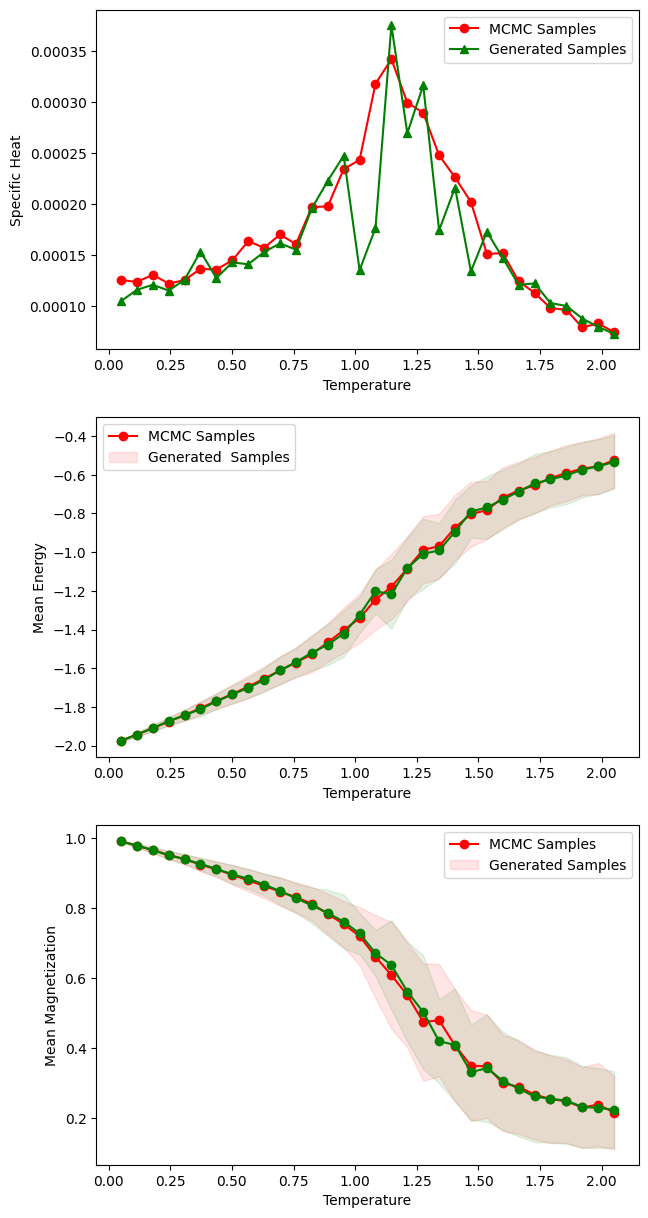

In [22]:
comparison_plot_with_different_ensemble_size(mcmc_samples,mh_samples,1000,10000,0.05,2.05,32,J=1,K=0,name='comparison_plot')

In [23]:
    temp_len = 32
    min_t = 0.05
    max_t = 2.05
    lattices1 = mcmc_samples
    lattices2 = mh_samples
    index_set = np.arange(temp_len)
    T_vals = np.linspace(min_t,max_t,temp_len)
    samples1 = 1000
    samples2 = 10000
    J = 1
    K = 0

    #Empty arrays for holding lattices1 and lattices2 energy 
    lattices1_energy  = []
    lattices2_energy  = []
    lattices1_mag     = []
    lattices2_mag     = []
    overlap_energy    = []
    overlap_mag       = []
    EMD_energy        = []
    EMD_mag           = []
    
    for i in index_set:
        [energy1,mean_energy1,var_energy1] = get_energy(lattices1[samples1*i:samples1*(i+1)],J,K)
        [energy2,mean_energy2,var_energy2] = get_energy(lattices2[samples2*i:samples2*(i+1)],J,K)

        hist1_energy,bin1_energy = np.histogram(np.array(energy1),bins =80,range=[-3, 0])
        hist2_energy,bin2_energy = np.histogram(np.array(energy2),bins =80,range=[-3, 0])

        [mag1,mean_mag1,mean_new1,mag_susceptibility1] = calculate_magnetization(lattices1[samples1*i:samples1*(i+1)])
        [mag2,mean_mag2,mean_new2,mag_susceptibility2] = calculate_magnetization(lattices2[samples2*i:samples2*(i+1)])
        
        hist1_mag,bin1_mag = np.histogram(mag1,bins =40,range=[0, 1])
        hist2_mag,bin2_mag = np.histogram(mag2,bins =40,range=[0, 1])
        
        overlap_energy.append(percent_overlap(hist1_energy,hist2_energy/10))
        overlap_mag.append(percent_overlap(hist1_mag,hist2_mag/10))
        
        EMD_energy.append(earth_mover_distance(hist2_energy/10,hist1_energy))
        EMD_mag.append(earth_mover_distance(hist2_mag/10,hist1_mag))
    
    Energy_overlap         = [np.mean(np.array(overlap_energy)),np.std(np.array(overlap_energy))]
    Magnetization_overlap  = [np.mean(np.array(overlap_mag)),np.std(np.array(overlap_mag))]
    Energy_wass_dist       = [np.mean(np.array(EMD_energy)),np.std(np.array(EMD_energy))]
    Magnetization_wass_dist= [np.mean(np.array(EMD_mag)),np.std(np.array(EMD_mag))]
   
    

In [24]:
print(Energy_overlap)
print(Magnetization_overlap)
print(Energy_wass_dist)
print(Magnetization_wass_dist)

[87.7165625, 12.059021417950701]
[86.9453125, 12.537561312007359]
[0.005223984375000004, 0.005971074092989855]
[0.013002421875000003, 0.017596476204018354]
